## **Uploading Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

base_dir = "/content/drive/MyDrive/Deepfake_Project/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")
val_dir   = os.path.join(base_dir, "validate")

print("Train path:", train_dir)
print("Classes:", os.listdir(train_dir))

Train path: /content/drive/MyDrive/Deepfake_Project/dataset/train
Classes: ['1', '0']


In [ ]:
!pip install scikit-learn opencv-python matplotlib tqdm scikit-image

In [18]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import random
from sklearn.model_selection import cross_val_score
from random import sample
from google.colab import files

In [4]:
base_dir = "/content/drive/MyDrive/Deepfake_Project/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validate")

print("Train:", train_dir)
print("Test:", test_dir)
print("Valid:", val_dir)

Train: /content/drive/MyDrive/Deepfake_Project/dataset/train
Test: /content/drive/MyDrive/Deepfake_Project/dataset/test
Valid: /content/drive/MyDrive/Deepfake_Project/dataset/validate


## **Analyze Dataset**

Total Real Images: 5000
Total Fake Images: 5000


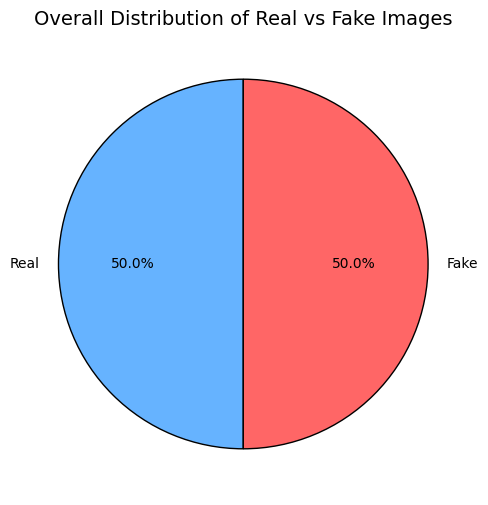

In [7]:
splits = ['train', 'validate', 'test']

# Function to count images in each class folder
def count_images(folder):
    real_path = os.path.join(folder, '0')
    fake_path = os.path.join(folder, '1')
    num_real = len(os.listdir(real_path)) if os.path.exists(real_path) else 0
    num_fake = len(os.listdir(fake_path)) if os.path.exists(fake_path) else 0
    return num_real, num_fake

# Count images per split
counts = {}
total_real, total_fake = 0, 0
for split in splits:
    path = os.path.join(base_dir, split)
    real, fake = count_images(path)
    counts[split] = {'Real': real, 'Fake': fake}
    total_real += real
    total_fake += fake

# Print totals
print(f"Total Real Images: {total_real}")
print(f"Total Fake Images: {total_fake}")

# --- One combined pie chart ---
plt.figure(figsize=(6,6))
plt.pie(
    [total_real, total_fake],
    labels=['Real', 'Fake'],
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff6666'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Overall Distribution of Real vs Fake Images", fontsize=14)
plt.show()

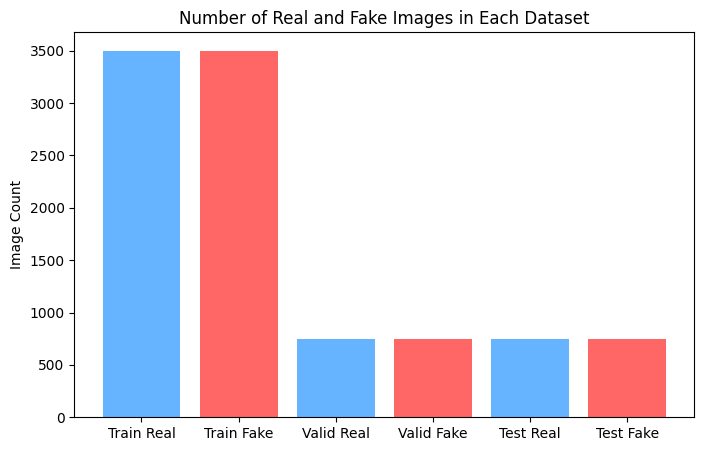

In [8]:
plt.figure(figsize=(8,5))
plt.bar(['Train Real', 'Train Fake', 'Valid Real', 'Valid Fake', 'Test Real', 'Test Fake'],
        [counts['train']['Real'], counts['train']['Fake'],
         counts['validate']['Real'], counts['validate']['Fake'],
         counts['test']['Real'], counts['test']['Fake']],
        color=['#66b3ff', '#ff6666']*3)
plt.title("Number of Real and Fake Images in Each Dataset")
plt.ylabel("Image Count")
plt.xticks(rotation=0)
plt.show()

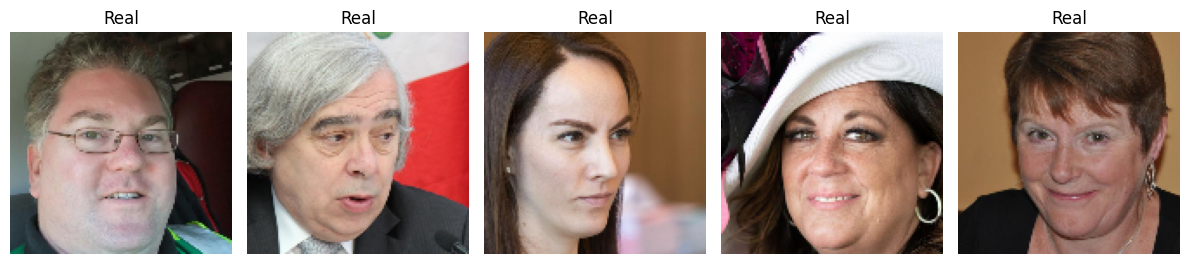

In [59]:
def show_real_samples(folder, n=5):
    real_folder = os.path.join(folder, '0')  # '0' = Real images
    images = os.listdir(real_folder)

    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(sample(images, min(n, len(images)))):
        img_path = os.path.join(real_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.resize(img, (128, 128)))
        plt.title("Real")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Show 5 random real images from training set
show_real_samples(train_dir, n=5)

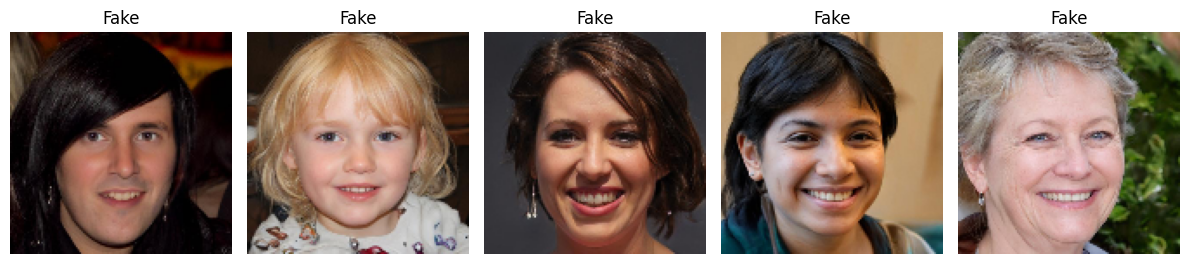

In [60]:
def show_fake_samples(folder, n=5):
    real_folder = os.path.join(folder, '1')
    images = os.listdir(real_folder)

    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(sample(images, min(n, len(images)))):
        img_path = os.path.join(real_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.resize(img, (128, 128)))
        plt.title("Fake")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ✅ Show 5 random fake images from training set
show_fake_samples(train_dir, n=5)

## **Loading and Preprocessing Images**

This function loads and preprocesses images for training and testing.

- **Loops through folders** labeled `'0'` (Real) and `'1'` (Fake).  
- **Reads each image** in grayscale using OpenCV.  
- **Resizes** every image to `128×128` pixels for uniformity.  
- **Normalizes** pixel values to a `0–1` range by dividing by 255.  
- **Flattens** each image from 2D → 1D (since Logistic Regression expects vectors).  
- **Stores** processed images and their corresponding labels in NumPy arrays.  

In [11]:
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    labels = []
    for label in ['0', '1']:
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder), desc=f"Loading {label_folder}"):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, size)
                img = img.astype('float32') / 255.0
                images.append(img.flatten())   # Flatten 2D → 1D vector
                labels.append(int(label))
    return np.array(images), np.array(labels)

In [12]:
X_train, y_train = load_images_from_folder(train_dir)
X_val, y_val = load_images_from_folder(val_dir)
X_test, y_test = load_images_from_folder(test_dir)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Loading /content/drive/MyDrive/Deepfake_Project/dataset/train/0: 100%|██████████| 3500/3500 [02:00<00:00, 29.13it/s] 
Loading /content/drive/MyDrive/Deepfake_Project/dataset/train/1: 100%|██████████| 3500/3500 [02:27<00:00, 23.81it/s] 
Loading /content/drive/MyDrive/Deepfake_Project/dataset/validate/0: 100%|██████████| 750/750 [00:27<00:00, 26.99it/s] 
Loading /content/drive/MyDrive/Deepfake_Project/dataset/validate/1: 100%|██████████| 750/750 [00:28<00:00, 26.62it/s] 
Loading /content/drive/MyDrive/Deepfake_Project/dataset/test/0: 100%|██████████| 750/750 [00:27<00:00, 27.14it/s] 
Loading /content/drive/MyDrive/Deepfake_Project/dataset/test/1: 100%|██████████| 750/750 [00:30<00:00, 24.51it/s] 


Train: (7000, 16384) (7000,)
Validation: (1500, 16384) (1500,)
Test: (1500, 16384) (1500,)


## **Model Training**
- Initializes a **Logistic Regression** model with:
  - `max_iter=1000` → ensures the model has enough iterations to converge.
  - `solver='lbfgs'` → an efficient optimization algorithm for small to medium datasets.
- Trains the model using `X_train` (features) and `y_train` (labels).
- Prints a confirmation message once training is successfully completed.

In [46]:
model = LogisticRegression(max_iter=1000, solver='lbfgs', C=0.01)
model.fit(X_train, y_train)

print("✅ Model training completed!")

✅ Model training completed!


## **Model Validation**
Uses the trained Logistic Regression model to **predict** labels for the validation set (`X_val`).  
- Compares the predicted labels with actual labels (`y_val`) using `accuracy_score`.  
- Displays the **validation accuracy** — showing how well the model performs on unseen data before final testing.

In [54]:
val_preds = model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)

print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Validation Accuracy: 86.67%


## **Model Evaluation Summary**

- The model performs well in distinguishing between real and fake images.  
- It achieves high accuracy on training (91.5%) and maintains strong performance on validation (86.7%) and test data (84.3%), showing good generalization.  
- The ROC AUC score of 0.9247 indicates excellent ability to separate real and fake classes.  
- Both classes (Real and Fake) have balanced precision and recall, meaning the model predicts each class reliably.  
- Overall, the model demonstrates robust and consistent performance for deepfake detection.


Model Evaluation Results
Training Accuracy: 91.51%
Validation Accuracy: 86.67%
Test Accuracy: 84.33%
ROC AUC Score: 0.9247

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.84      0.85      0.85       750
    Fake (1)       0.85      0.83      0.84       750

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



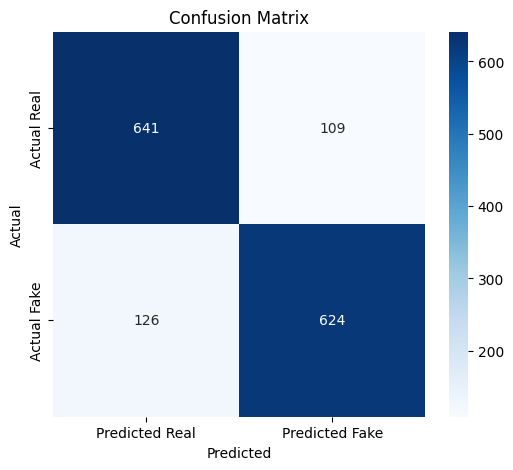

In [55]:
# Model evaluation
train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))
test_preds = model.predict(X_test)
test_proba = model.predict_proba(X_test)[:, 1]
test_acc = accuracy_score(y_test, test_preds)
roc_auc = roc_auc_score(y_test, test_proba)

# Results
print("="*50)
print("Model Evaluation Results")
print("="*50)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, test_preds, target_names=['Real (0)', 'Fake (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

The ROC AUC score of 0.92 indicates that the model has excellent performance and a 92% chance of correctly ranking a randomly chosen positive case higher than a randomly chosen negative case.

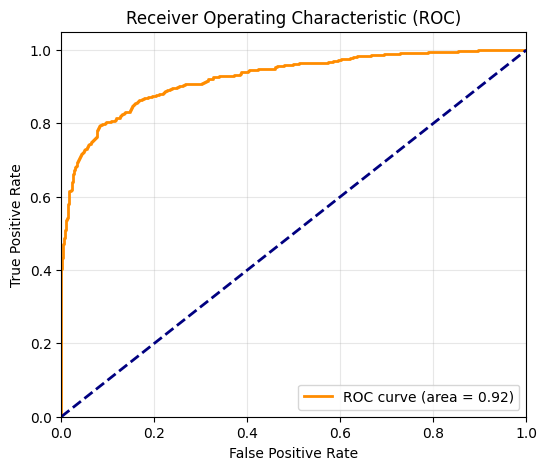

In [56]:
# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Cross-validation mean accuracy: 83.5%, confirming consistent performance across folds.

In [57]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print("CV Mean Accuracy:", scores.mean())

CV Mean Accuracy: 0.8352857142857143


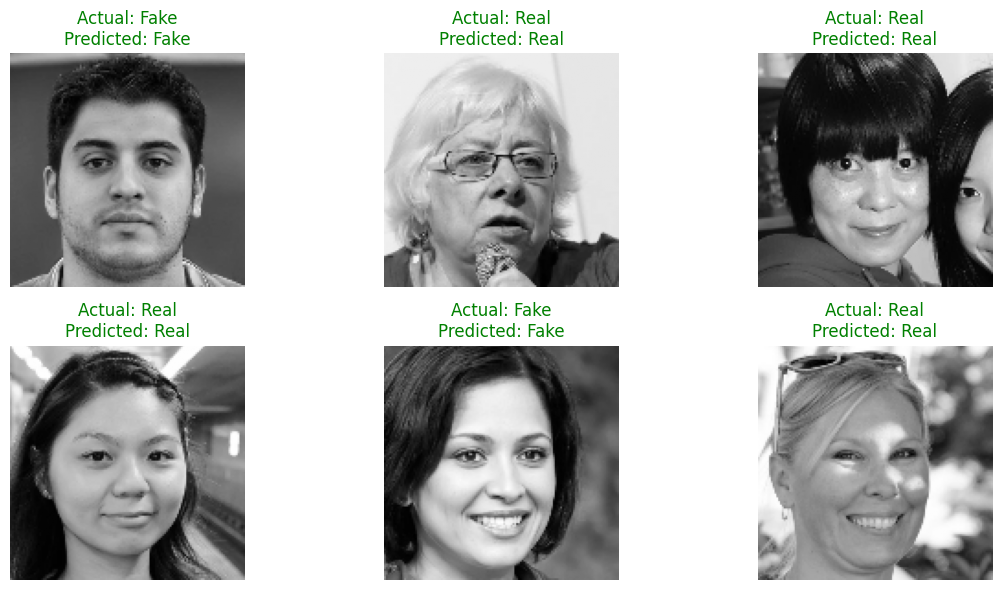

In [61]:
def show_sample_predictions(X, y_true, y_pred, n=6):
    plt.figure(figsize=(12, 6))

    # Pick random indices
    indices = random.sample(range(len(X)), n)

    for i, idx in enumerate(indices):
        # Reshape flattened image back to 128x128x3
        img = X[idx].reshape(128, 128) # Reshape to (128, 128) for grayscale
        img = np.clip(img, 0, 1) # Clip to 0-1 range for float images

        actual = "Real" if y_true[idx] == 0 else "Fake"
        predicted = "Real" if y_pred[idx] == 0 else "Fake"

        # Color title: green if correct, red if incorrect
        color = "green" if actual == predicted else "red"

        plt.subplot(2, 3, i + 1)
        plt.imshow(img, cmap='gray') # Use gray colormap for grayscale images
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔍 Display 6 random sample predictions
show_sample_predictions(X_test, y_test, test_preds, n=6)

Saving 0a46993c51c0acaa4bfe52e2d26bfb0ce102f2cd30cee1d06ff15befef8df2eb.jpg to 0a46993c51c0acaa4bfe52e2d26bfb0ce102f2cd30cee1d06ff15befef8df2eb.jpg


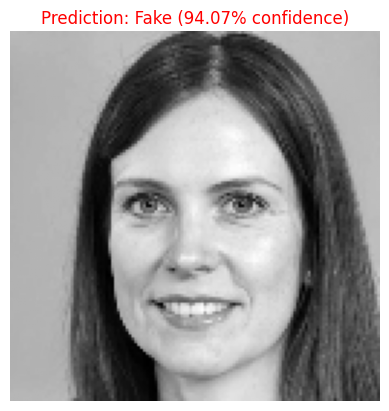

In [63]:
from google.colab import files

def predict_single_image(model):
    # Step 1: Upload image
    uploaded = files.upload()

    for file_name in uploaded.keys():
        # Step 2: Load the image in grayscale and resize to match training size
        img_path = file_name
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img_resized = cv2.resize(img, (128, 128))

        # Step 3: Normalize and Flatten
        img_normalized = img_resized.astype('float32') / 255.0
        img_flat = img_normalized.flatten().reshape(1, -1)

        # Step 4: Make prediction
        pred = model.predict(img_flat)[0]
        prob = model.predict_proba(img_flat)[0][1]  # Probability for 'Fake' class

        # Step 5: Label and result
        label = "Fake" if pred == 1 else "Real"
        confidence = prob if pred == 1 else 1 - prob

        # Step 6: Display image and prediction
        # Display the grayscale image
        plt.imshow(img_resized, cmap='gray')
        plt.title(f"Prediction: {label} ({confidence*100:.2f}% confidence)",
                  color="red" if label == "Fake" else "green")
        plt.axis('off')
        plt.show()

# Run this cell to upload and test
predict_single_image(model)